# Vehicle detection project

## The goals of this project are
* Scan all the road lanes until the road horizon
* Classify the objects as cars and non-cars appearing on the road
* Identify the HOG features of objects on the road
* Build an SVM classifier for car/noncar using HOG features
* Using sliding windows, reduce processing unnecessary areas in the image
* Use heatmap thresholds and scikit labels to eliminate false positives
* Define a pipeline for this entire processing and run it on streaming video


In [50]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

%matplotlib inline



## Read training data

In [51]:
cars = glob.glob('training_data/vehicles/**/*.png')
noncars = glob.glob('training_data/non-vehicles/**/*.png')
print("training stats: ")
print("number of cars: ", len(cars))
print("number of noncars: ", len(noncars))

training stats: 
number of cars:  8792
number of noncars:  8968


## View the training data

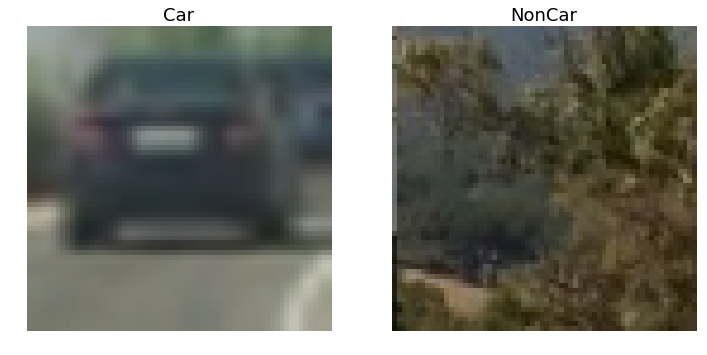

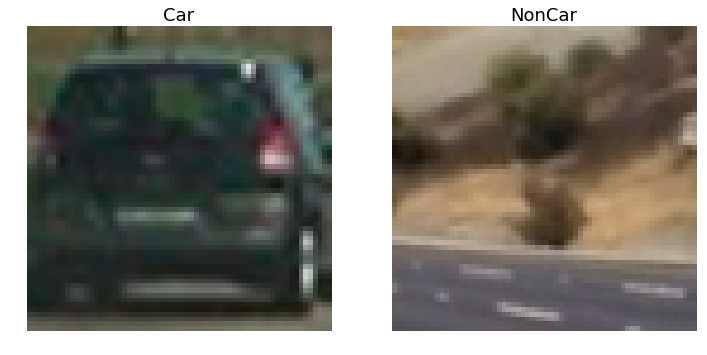

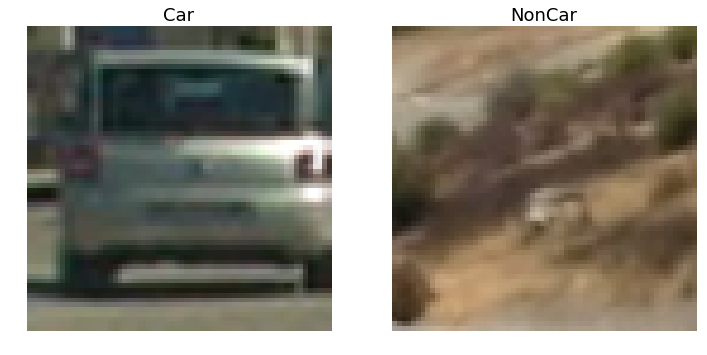

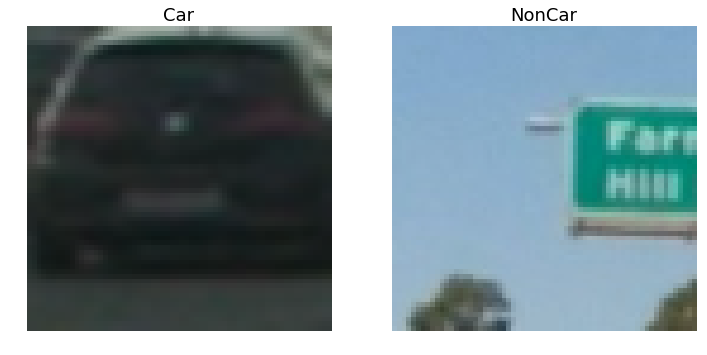

In [52]:
# random cars to display
indices = [1, 299, 399, 499]
for i in range(len(indices)):
    #print(cars[indices[i]])
    #print(noncars[indices[i]])
    image = mpimg.imread(cars[indices[i]])
    image2 = mpimg.imread(noncars[indices[i]])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image)
    ax1.set_title('Car', fontsize=18)
    ax1.axis('off')
    ax2.imshow(image2)
    ax2.set_title('NonCar', fontsize=18)
    ax2.axis('off')

## Extract features from training data
Reused code from udacity lectures

In [53]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [54]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [55]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

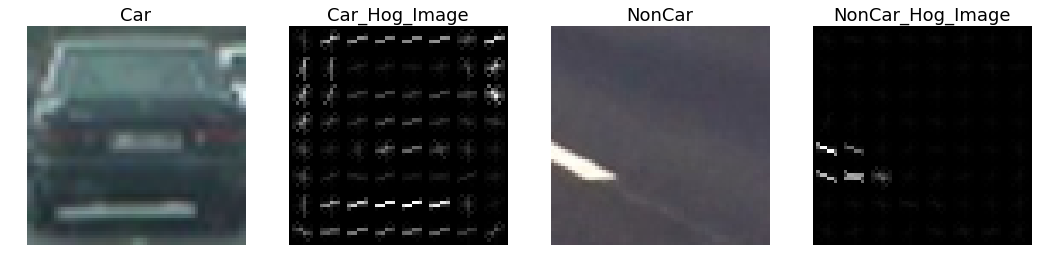

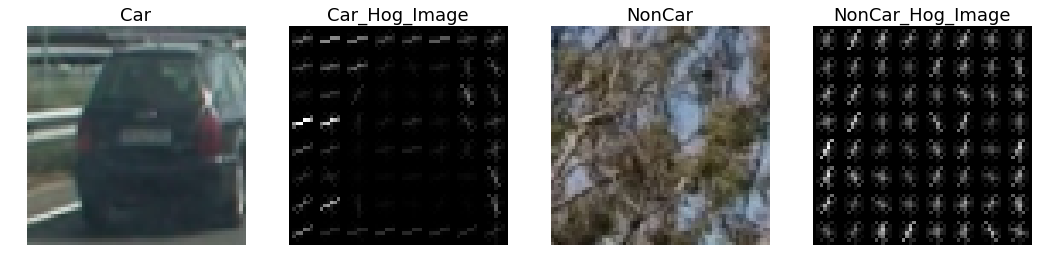

In [56]:
indices = [702, 890]
for i in range(len(indices)):
    image = mpimg.imread(cars[indices[i]])
    image2 = mpimg.imread(noncars[indices[i]])
    feats, car_hog_image = get_hog_features(image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    feats2, noncar_hog_image = get_hog_features(image2[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6))
    ax1.imshow(image)
    ax1.set_title('Car', fontsize=18)
    ax1.axis('off')
    ax2.imshow(car_hog_image, cmap='gray')
    ax2.set_title('Car_Hog_Image', fontsize=18)
    ax2.axis('off')
    ax3.imshow(image2)
    ax3.set_title('NonCar', fontsize=18)
    ax3.axis('off')
    ax4.imshow(noncar_hog_image, cmap='gray')
    ax4.set_title('NonCar_Hog_Image', fontsize=18)
    ax4.axis('off')

In [57]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),  orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

## Extract features from all training data images

In [58]:

cspace = 'YCrCb' 
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncars, cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=rand_state)
print("....")

....


## Train an SVM Classifier

In [59]:
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time()
n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 1188
1.01 Seconds to train SVC...
Test Accuracy of SVC =  0.9859
SVC predicts:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.]
0.00145 Seconds to predict 10 labels with SVC


## Use sliding windows to find cars using SVM classifier

In [33]:
def convert_color(img, conv):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [34]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_bounding_box_corners = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
 
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_bounding_box_corners.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return car_bounding_box_corners

## Draw Bounding boxes for Cars

In [35]:
def draw_car_bounding_boxes(img, bboxes):
    new_img = np.copy(img)
    colors = [(0,0,255), (0,255,0),(255,0,0), (255,255,0), (0,255,255), (255,0,255)]
    i = 0
    for bbox in bboxes:
        cv2.rectangle(new_img, bbox[0], bbox[1], colors[i], 3)
        i = i+1
        if (i > 5):
            i = 0
    return new_img

print('...')

...


...


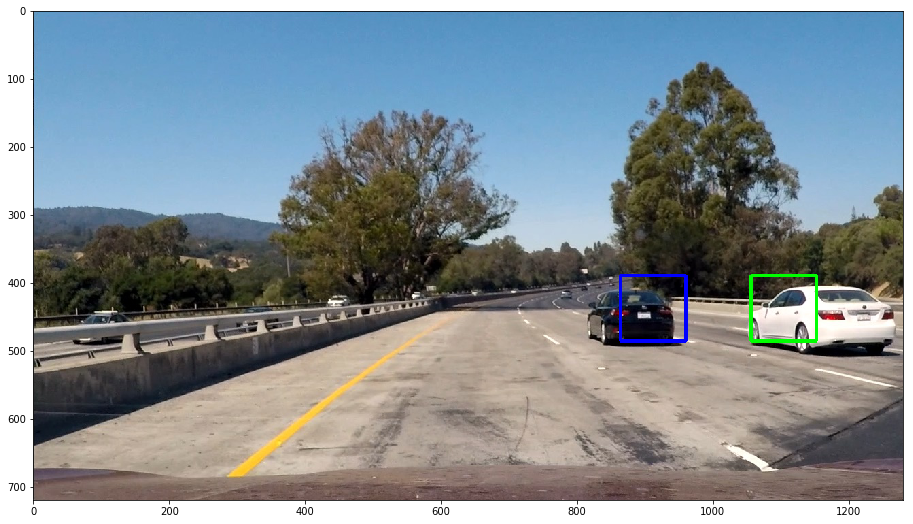

In [36]:
spatial_size=32
hist_bins=32
img = mpimg.imread('./test_images/test1.jpg')
ystart = 390
ystop = 640
scale = 1.5
bboxes = find_cars(img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace)
bbox_rects = draw_car_bounding_boxes(img, bboxes)
plt.figure(figsize=(24,9))
plt.imshow(bbox_rects)
print('...')

## Experiment with interesting areas in the video images to locate cars

...


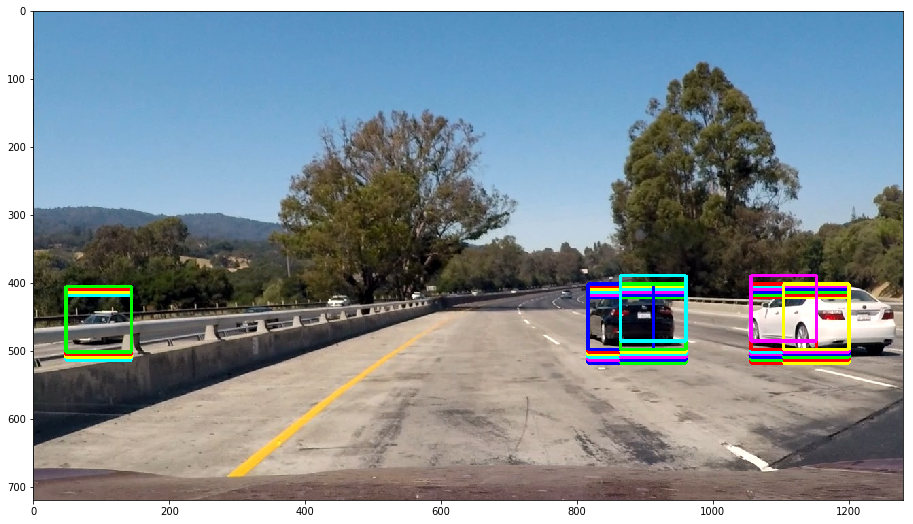

In [37]:
img = mpimg.imread('./test_images/test1.jpg')
ystart = 390
ystop = 640
scale = 1.5
increments = [0, 12, 16, 20, 24, 28,32]
bboxes_all = []
bboxes_prev = []
for i in increments:
    ystart1 = ystart+i;
    ystop1 = ystop+i;
    bboxes = find_cars(img, ystart1, ystop1, scale, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace)
    bboxes_prev = bboxes+bboxes_prev

bbox_rects = draw_car_bounding_boxes(img, bboxes_prev)
plt.figure(figsize=(24,9))
plt.imshow(bbox_rects)
print('...')

## Use Heatmaps to reduce false positives

In [38]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

print('...')

...


...


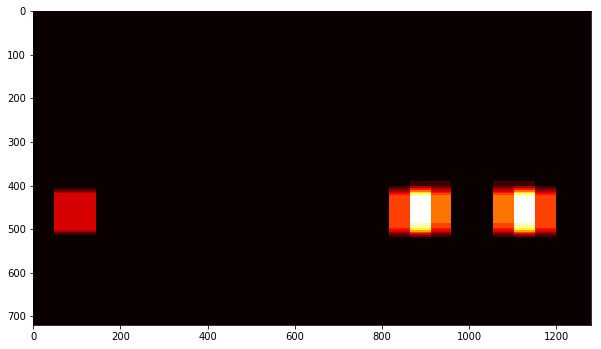

In [39]:
img = mpimg.imread('./test_images/test1.jpg')
hm_img = np.zeros_like(img[:,:,0])
heat_img = add_heat(hm_img, bboxes_prev)
plt.figure(figsize=(10,10))
plt.imshow(heat_img, cmap='hot')

print('...')

In [40]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

...


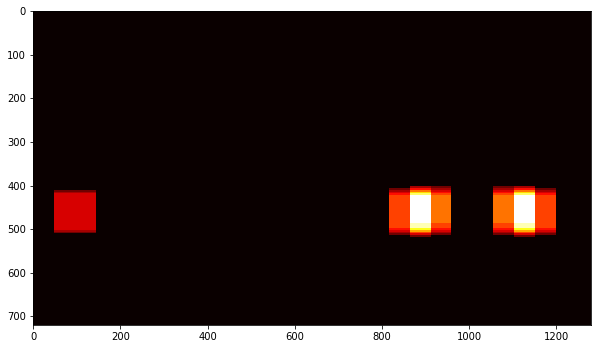

In [41]:
heat_img = apply_threshold(heat_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heat_img, cmap='hot')

print('...')

## Use scikit labels

3 cars found


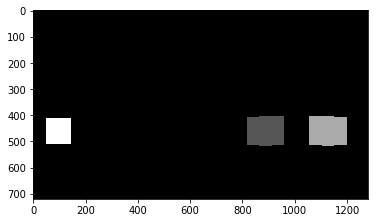

In [42]:
heatmap = apply_threshold(heat_img, 1)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [43]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

...


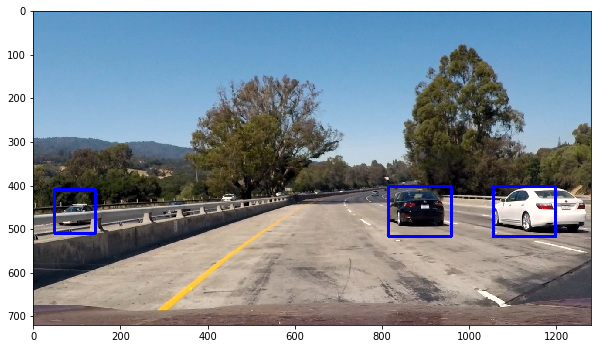

In [44]:
draw_img = draw_labeled_bboxes(np.copy(img), labels)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

## Build pipeline for video processing

In [45]:
def pipeline_video(img):
    ystart = 390
    ystop = 640
    scale = 1.5
    increments = [0, 12, 16, 20, 24, 28,32]
    bboxes_all = []
    new_img = np.copy(img)
    for i in increments:
        ystart1 = ystart+i;
        ystop1 = ystop+i;
        bboxes = find_cars(img, ystart1, ystop1, scale, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace)
        bboxes_all = bboxes+bboxes_all
    #bbox_rects = draw_car_bounding_boxes(img, bboxes_all)
    
    heatmap = np.zeros_like(img[:,:,0])
    heatmap = add_heat(heatmap, bboxes_all)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


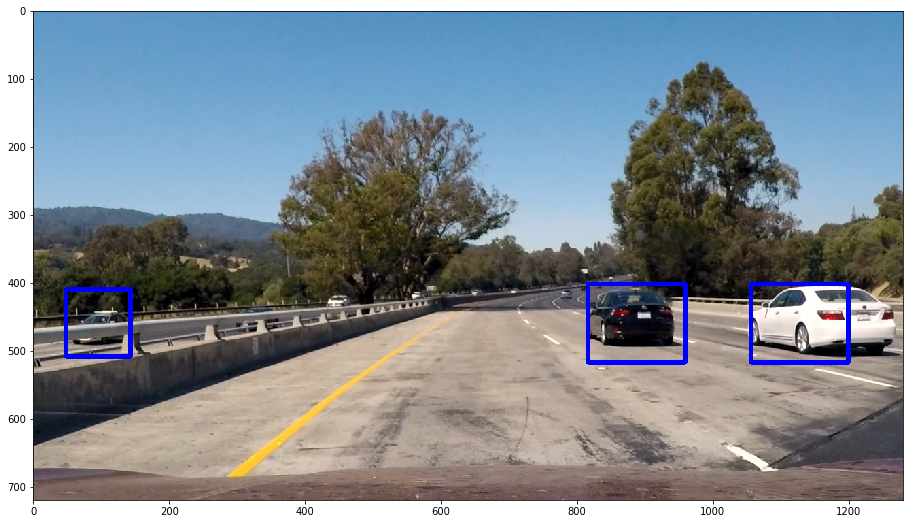

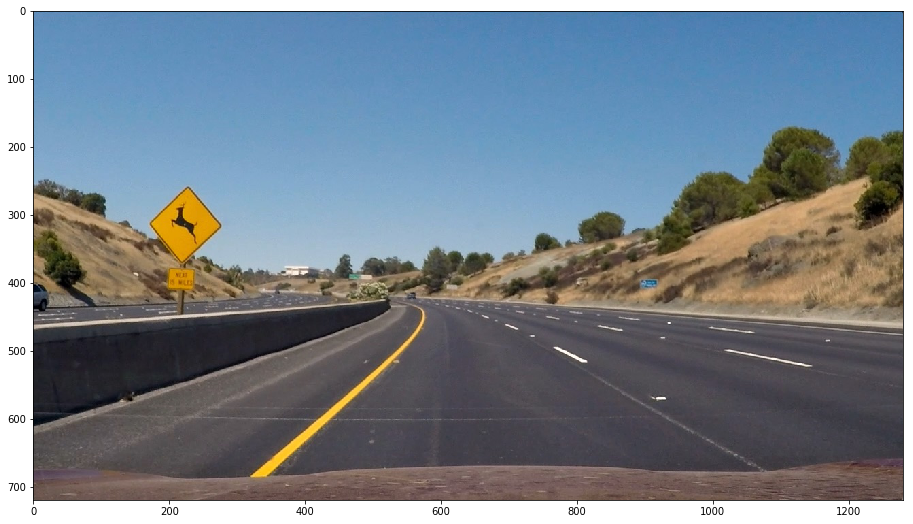

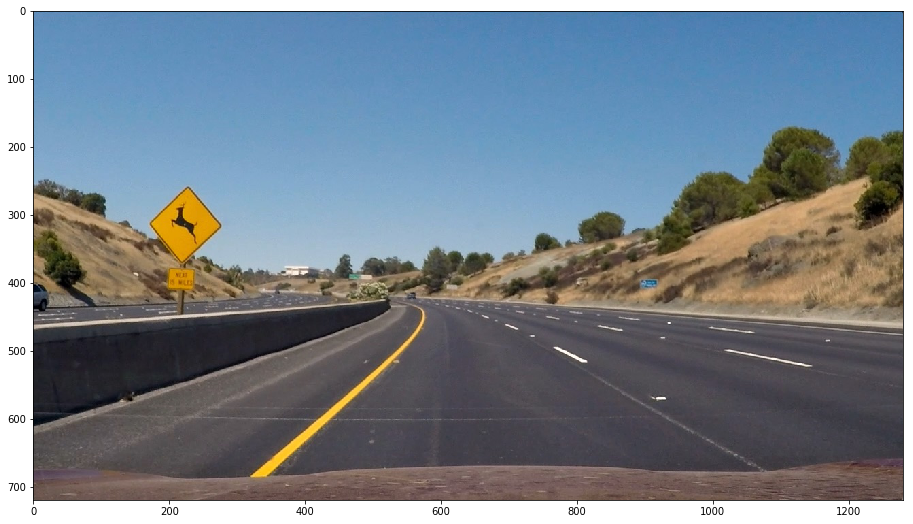

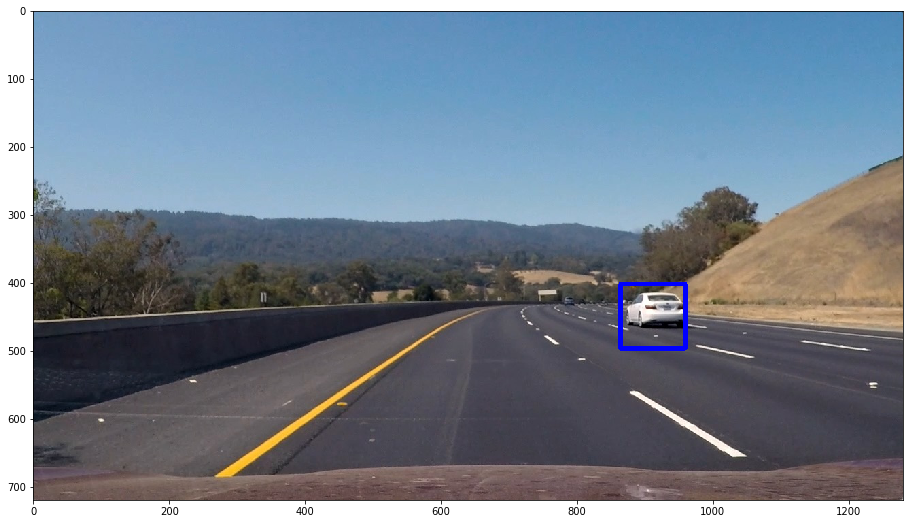

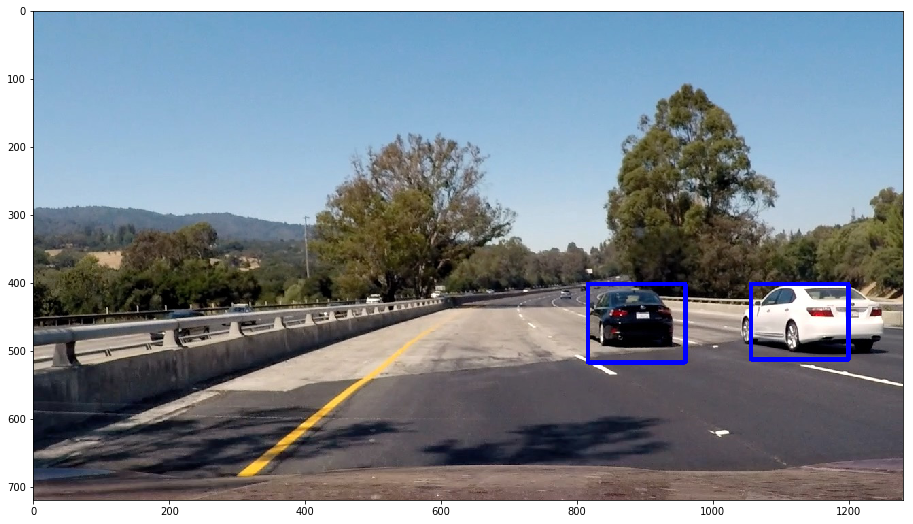

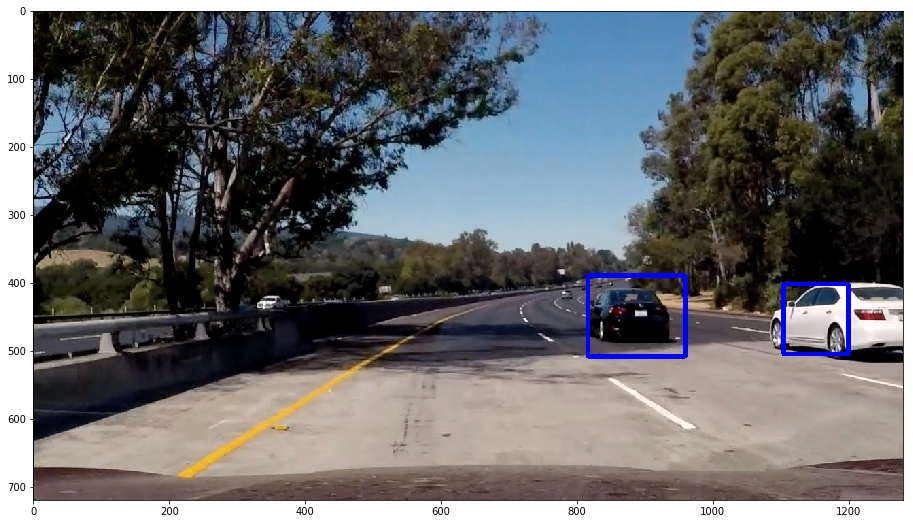

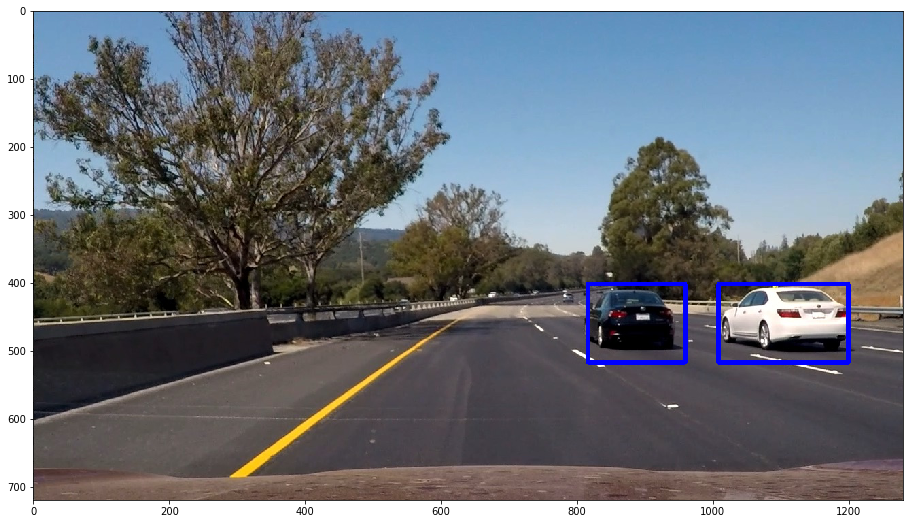

In [46]:
images = glob.glob('./test_images/test*.jpg')

for i, filename in enumerate(images):
    bboxes = pipeline_video(mpimg.imread(filename))
    plt.figure(figsize=(16,9))
    plt.imshow(bboxes)
    

## Test on project video

In [47]:
video_out = 'ai_cars.mp4'
vclip = VideoFileClip('project_video.mp4')#.subclip(28, 38)
ai_video = vclip.fl_image(pipeline_video)
ai_video.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video ai_cars.mp4
[MoviePy] Writing video ai_cars.mp4


100%|█████████▉| 1260/1261 [14:15<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ai_cars.mp4 



In [48]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('ai_cars.mp4'))